In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Memory-efficient data loading by reading a smaller fraction of the data
data = pd.read_csv('../input/cic-ids-2018updated/CIC-IDS-2018(15).csv', low_memory=False)

# Take a random sample of 5% to reduce memory usage
data = data.sample(frac=0.05, random_state=42)

# Drop 'Timestamp' column (it's unnecessary for clustering)
data = data.drop(['Timestamp'], axis=1)

# Select a subset of important features (10 numerical columns + 'Label') to optimize memory usage
selected_columns = [
    'Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Duration',
    'Label'
]
data = data[selected_columns]

# Apply one-hot encoding to the categorical 'Dst Port' column
data = pd.get_dummies(data, columns=['Dst Port'], drop_first=True)

# Drop rows with missing values to ensure data integrity
data = data.dropna()

# Function to downcast numeric columns to optimize memory usage
def downcast_dataframe(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    return df

# Downcast the dataframe to save memory
data = downcast_dataframe(data)

# Encode the 'Label' column into numerical values using Label Encoding
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Split the data into features (X) and labels (y)
X = data.drop(['Label'], axis=1)  # Features are all columns except 'Label'
y = data['Label']  # Labels are in the 'Label' column

# Standardize the feature data for better training performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply PCA to reduce dimensionality to 10 components to improve clustering efficiency
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Output the shape of the processed data to verify memory efficiency
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")


X_train_pca shape: (28994, 10)
X_test_pca shape: (12427, 10)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# WGAN-GP loss functions
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(discriminator, real_images, fake_images):
    epsilon = tf.random.uniform([real_images.shape[0], 1], 0.0, 1.0)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)
    gradients = tape.gradient(predictions, interpolated_images)
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

class WGAN_GP:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.lambda_gp = 10.0  # Weight for gradient penalty

    def build_generator(self):
        model = tf.keras.Sequential([
            layers.Dense(256, input_dim=self.latent_dim),
            layers.LeakyReLU(),
            layers.Dense(512),
            layers.LeakyReLU(),
            layers.Dense(self.input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self):
        model = tf.keras.Sequential([
            layers.Dense(512, input_dim=self.input_dim),
            layers.LeakyReLU(),
            layers.Dense(256),
            layers.LeakyReLU(),
            layers.Dense(1, activation=None)  # No activation function for WGAN
        ])
        return model

    def train_wgan(self, real_images, epochs):
        for epoch in range(epochs):
            noise = np.random.normal(0, 1, (real_images.shape[0], self.latent_dim))
            fake_images = self.generator(noise)
            
            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(real_images)
                fake_output = self.discriminator(fake_images)
                d_loss_real = tf.reduce_mean(real_output)
                d_loss_fake = tf.reduce_mean(fake_output)
                gp = gradient_penalty(self.discriminator, real_images, fake_images)
                d_loss = d_loss_fake - d_loss_real + self.lambda_gp * gp

            gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
            
            # Train generator
            with tf.GradientTape() as gen_tape:
                noise = np.random.normal(0, 1, (real_images.shape[0], self.latent_dim))
                generated_images = self.generator(noise)
                fake_output = self.discriminator(generated_images)
                g_loss = -tf.reduce_mean(fake_output)

            gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        
        return d_loss, g_loss



In [5]:
class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(2 * latent_dim)  # Mean and log variance for latent space
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(input_dim)  # Output reconstruction
        ])

    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + epsilon * tf.exp(log_var * 0.5)

    def call(self, inputs):
        mean, log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var
    
# Contrastive loss for clustering
def contrastive_loss(embeddings, labels, margin=1.0):
    pairwise_distances = tf.norm(embeddings[:, None] - embeddings[None, :], axis=-1)
    same_label_mask = tf.equal(labels[:, None], labels[None, :])
    loss_same = pairwise_distances * tf.cast(same_label_mask, tf.float32)
    loss_diff = tf.maximum(margin - pairwise_distances, 0.0) * tf.cast(~same_label_mask, tf.float32)
    return tf.reduce_mean(loss_same + loss_diff)

# Personalized Federated Learning (pFedMe)
class pFedMe:
    def __init__(self, clients, global_model):
        self.clients = clients
        self.global_model = global_model
        self.client_weights = [client.get_weights() for client in clients]

    def train(self, rounds=10):
        for round_num in range(rounds):
            # Train each client model
            for i, client in enumerate(self.clients):
                client.train()
                self.client_weights[i] = client.get_weights()

            # Update the global model
            avg_weights = np.mean(self.client_weights, axis=0)
            self.global_model.set_weights(avg_weights)

# Client Movement Simulation with Temporal Clustering
def simulate_movement(X_initial, num_time_steps, movement_scale):
    X_movement = [X_initial.copy()]
    for t in range(1, num_time_steps):
        movement = np.random.normal(0, movement_scale, size=X_initial.shape)
        X_new = X_movement[-1] + movement
        X_movement.append(X_new)
    return X_movement




/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.9807
Epoch 2/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0241
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9824
Epoch 4/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9925
Epoch 5/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9741
Epoch 6/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9761
Epoch 7/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9770
Epoch 8/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9991
Epoch 9/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9915
Epoch 10/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0000
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


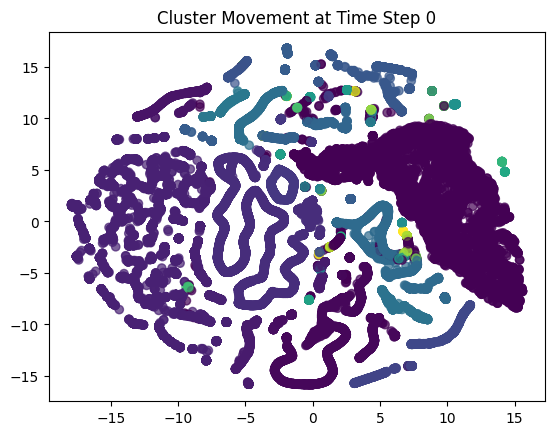

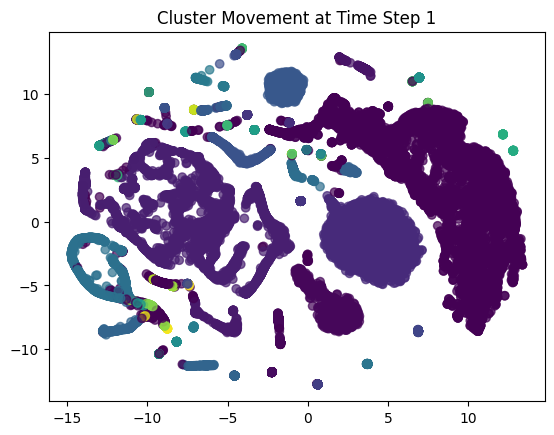

Time Step 1: ARI Score = 0.1329, Silhouette Score = 0.4393


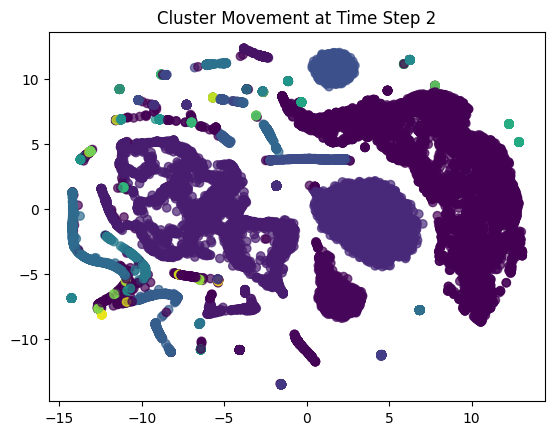

Time Step 2: ARI Score = 0.1339, Silhouette Score = 0.4123


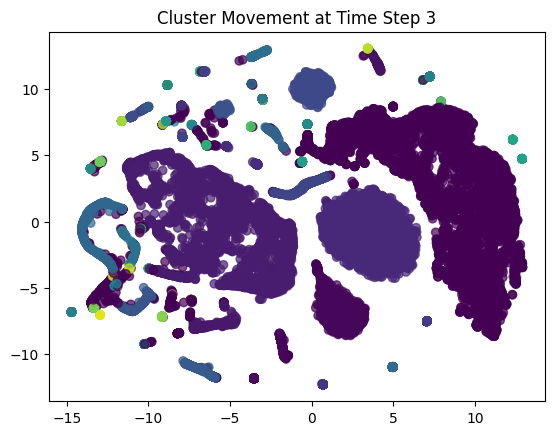

Time Step 3: ARI Score = 0.1366, Silhouette Score = 0.3968


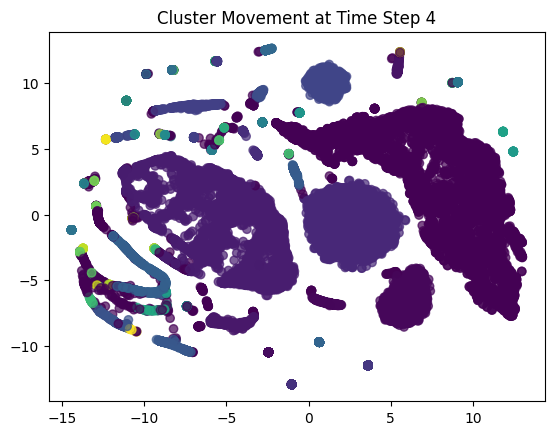

Time Step 4: ARI Score = 0.1395, Silhouette Score = 0.3717


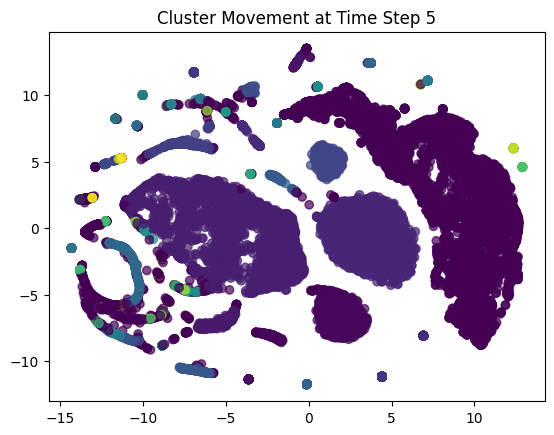

Time Step 5: ARI Score = 0.1441, Silhouette Score = 0.3431


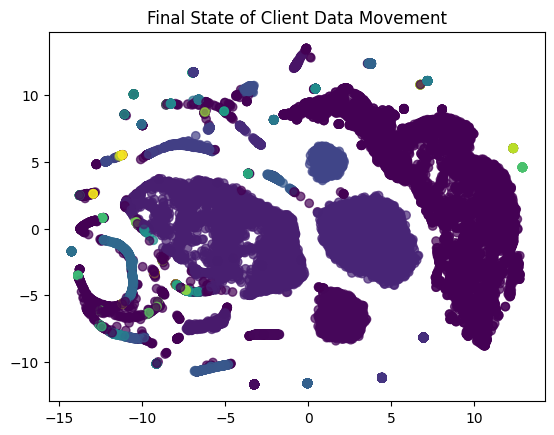

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Function to simulate client data movement over time with smaller movement
def simulate_movement(data, num_time_steps, movement_scale=0.03):
    X_movement = [data]
    for _ in range(num_time_steps):
        new_position = X_movement[-1] + np.random.normal(scale=movement_scale, size=data.shape)
        X_movement.append(new_position)
    return X_movement

# Initialize and train WGAN-GP using CICIDS 2018 data
gan = WGAN_GP(input_dim=X_train.shape[1], latent_dim=15)  # Increased latent dimension to 15
d_loss, g_loss = gan.train_wgan(X_train, epochs=100)

# Initialize and train VAE for feature extraction
vae = VAE(input_dim=X_train.shape[1], latent_dim=15)  # Increased latent dimension to 15
vae.compile(optimizer='adam', loss='mse')
vae.fit(X_train, X_train, epochs=10, verbose=1)

# Extract latent features from the trained VAE
latent_train = vae.encoder.predict(X_train)
X_movement = simulate_movement(latent_train, num_time_steps=5, movement_scale=0.03)

# Apply t-SNE for more jumbled clustering and calculate clustering accuracy
for time_step, X_step in enumerate(X_movement):
    tsne = TSNE(n_components=2, perplexity=50, n_iter=300)  # Using t-SNE for better jumbled visualization
    X_tsne = tsne.fit_transform(X_step)
    
    # Perform DBSCAN clustering for a more flexible clustering approach
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    y_pred = dbscan.fit_predict(X_step)
    
    # Plot the clusters
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, alpha=0.7, cmap='viridis')
    plt.title(f'Cluster Movement at Time Step {time_step}')
    plt.show()

    # Calculate clustering accuracy using Adjusted Rand Index (ARI) or silhouette score
    if time_step > 0 and len(set(y_pred)) > 1:  # ARI requires more than 1 unique cluster
        ari_score = adjusted_rand_score(y_train, y_pred)  # Compare true labels vs. predicted clusters
        silhouette_avg = silhouette_score(X_step, y_pred) if len(set(y_pred)) > 1 else -1
        print(f"Time Step {time_step}: ARI Score = {ari_score:.4f}, Silhouette Score = {silhouette_avg:.4f}")

# Final cluster state visualization
X_final_tsne = tsne.fit_transform(X_movement[-1])
plt.scatter(X_final_tsne[:, 0], X_final_tsne[:, 1], c=y_pred, alpha=0.7, cmap='viridis')
plt.title('Final State of Client Data Movement')
plt.show()

# Output final losses and accuracy metrics
print(f'Final GAN Loss: {g_loss[-1]}')
